# COMP579 Assignment 2

Authors:
* Ryan Reszetnik: 260948454
* Mathieu Geoffroy: 260986559

**Coding: Tabular RL [70 points]**

In [159]:
import gym
import numpy as np
import matplotlib.pyplot as plt

In [160]:
def softmax(x, temp):
    # write your solution here
    e = np.exp((x - np.max(x)) / temp)
    return e / e.sum(axis=0)

In [161]:
class Sarsa:
    def __init__(self, env, alpha, gamma, temp):
        # write your solution here
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.temp = temp
        self.Q = np.zeros([env.observation_space.n, env.action_space.n])

    def select_action(self, s, greedy=False):
        # write your solution here
        if greedy:
            return np.argmax(self.Q[s])
        else:
            return np.random.choice(self.env.action_space.n, p=softmax(self.Q[s], self.temp))

    def update(self, s, a, r, s_prime, a_prime, done):
        # write your solution here
        prediction = self.Q[s, a]
        target = r + (self.gamma * self.Q[s_prime, a_prime]) * (1 - done)
        self.Q[s, a] += self.alpha * (target - prediction)
        return self.Q


class ExpectedSarsa:
    def __init__(self, env, alpha, gamma, temp):
        # write your solution here
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.temp = temp
        self.Q = np.zeros([env.observation_space.n, env.action_space.n])

    def select_action(self, s, greedy=False):
        # write your solution here
        if greedy:
            # if finished training, then choose the optimal policy
            return np.argmax(self.Q[s])
        else:
            return np.random.choice(self.env.action_space.n, p=softmax(self.Q[s], self.temp))

    def update(self, s, a, r, s_prime, a_prime, done):
        prediction = self.Q[s, a]
        if done:
            target = r
        else:
            target = r + self.gamma * np.sum(softmax(self.Q[s_prime, :], self.temp) * self.Q[s_prime, :])
        self.Q[s, a] += self.alpha * (target - prediction)
        return self.Q
        
        


# bonus question, optional
class Hybrid_Sarsa_Q:
    def __init__(self, env, alpha, gamma, temp):
        # write your solution here
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.temp = temp
        self.Q = np.zeros([env.observation_space.n, env.action_space.n])

    def select_action(self, s, greedy=False):
        # write your solution here
        if greedy:
            # if finished training, then choose the optimal policy
            return np.argmax(self.Q[s])
        else:
            return np.random.choice(self.env.action_space.n, p=softmax(self.Q[s], self.temp))

    def update(self, s, a, r, s_prime, a_prime, done):
        # write your solution here
        prediction = self.Q[s, a]
        if done:
            target = r
        else:
            target = r + self.gamma * ((1 - self.alpha) * np.max(self.Q[s_prime, :])) + self.alpha * np.sum(softmax(self.Q[s_prime, :], self.temp) * self.Q[s_prime, :])
        self.Q[s, a] += self.alpha * (target - prediction)
        return self.Q

# Write your experiment code below

In [162]:
env_name = 'Taxi-v3'
env = gym.make(env_name)
print("Action space:", env.action_space)
print("State space:", env.observation_space)

Action space: Discrete(6)
State space: Discrete(500)


In [163]:
# function that runs each episode
def run_episode(agent, env, train=False):
    s, _ = env.reset()
    done = False
    episode_reward = 0
    step = 0
    a = agent.select_action(s, not train)
    while not done and step < 500:
        s_prime, r, terminated, truncated, _ = env.step(a)
        done = terminated or truncated
        a_prime = agent.select_action(s_prime, not train)
        if train:
            agent.update(s, a, r, s_prime, a_prime, done)
        
        s = s_prime
        a = a_prime
        episode_reward += r
        step += 1
        
        if done:
            break
            
    return episode_reward
            
# function that runs each hyperparameter setting
def run_experiment(agent, env, num_segments):
    testing_rewards = np.zeros(num_segments)
    training_rewards = np.zeros(num_segments)
    for i in range(num_segments):
        for j in range(10):
            r = run_episode(agent, env, train=True)
            training_rewards[i] += r
        training_rewards[i] /= 10
        testing_rewards[i] = run_episode(agent, env, train=False)
    return training_rewards, testing_rewards


In [164]:
# define hyperparameter arrays
num_segments = 500
alphas = list(np.logspace(-2, 0.3, 4))
gamma = 0.99
temps = list(np.logspace(-10, 2, 4))
num_trials = 10

In [165]:
# define sarsa agent
sarsa_agents = [Sarsa(env, alpha, gamma, temp) for alpha in alphas for temp in temps]

# define result array
sarsa_test_rewards = np.zeros((num_trials, len(alphas), len(temps), num_segments))
sarsa_train_rewards = np.zeros((num_trials, len(alphas), len(temps), num_segments))

# run experiments for sarsa
for agent in sarsa_agents:
    print(f"Running experiment for sarsa with alpha={agent.alpha}, gamma={agent.gamma}, temp={agent.temp}...")
    for trial in range(num_trials):
        agent.__init__(env, agent.alpha, agent.gamma, agent.temp)
        sarsa_train_rewards[trial, alphas.index(agent.alpha), temps.index(agent.temp)], sarsa_test_rewards[trial, alphas.index(agent.alpha), temps.index(agent.temp)] = run_experiment(agent, env, num_segments)
        print(f"\tTrial {trial} Reward: {sarsa_test_rewards[trial, alphas.index(agent.alpha), temps.index(agent.temp), -10:].mean()}")
        
# save results
np.save("sarsa_test_rewards.npy", sarsa_test_rewards)
np.save("sarsa_train_rewards.npy", sarsa_train_rewards)

Running experiment for sarsa with alpha=0.01, gamma=0.99, temp=1e-10...


	Trial 0 Reward: -115.6
	Trial 1 Reward: -379.1
	Trial 2 Reward: -337.4
	Trial 3 Reward: -335.8
	Trial 4 Reward: -115.0
	Trial 5 Reward: -535.0
	Trial 6 Reward: -157.5
	Trial 7 Reward: -316.3
	Trial 8 Reward: -358.0
	Trial 9 Reward: -337.2
Running experiment for sarsa with alpha=0.01, gamma=0.99, temp=1e-06...
	Trial 0 Reward: -178.7
	Trial 1 Reward: -136.5
	Trial 2 Reward: -178.7
	Trial 3 Reward: -178.5
	Trial 4 Reward: -316.2
	Trial 5 Reward: -354.0
	Trial 6 Reward: -200.0
	Trial 7 Reward: -179.0
	Trial 8 Reward: -377.3
	Trial 9 Reward: -559.1
Running experiment for sarsa with alpha=0.01, gamma=0.99, temp=0.01...
	Trial 0 Reward: -158.2
	Trial 1 Reward: -178.9
	Trial 2 Reward: -513.7
	Trial 3 Reward: -337.9
	Trial 4 Reward: -200.0
	Trial 5 Reward: -316.7
	Trial 6 Reward: -333.2
	Trial 7 Reward: -178.7
	Trial 8 Reward: -178.9
	Trial 9 Reward: -157.5
Running experiment for sarsa with alpha=0.01, gamma=0.99, temp=100.0...
	Trial 0 Reward: -158.0
	Trial 1 Reward: -200.0
	Trial 2 Reward: 

In [166]:
# define expected sarsa agent
expected_sarsa_agents = [ExpectedSarsa(env, alpha, gamma, temp) for alpha in alphas for temp in temps]

# define result array
expected_sarsa_test_rewards = np.zeros((num_trials, len(alphas), len(temps), num_segments))
expected_sarsa_train_rewards = np.zeros((num_trials, len(alphas), len(temps), num_segments))

# run experiments for expected sarsa
for agent in expected_sarsa_agents:
    print(f"Running experiment for expected sarsa with alpha={agent.alpha}, gamma={agent.gamma}, temp={agent.temp}...")
    for trial in range(num_trials):
        agent.__init__(env, agent.alpha, agent.gamma, agent.temp)
        expected_sarsa_train_rewards[trial, alphas.index(agent.alpha), temps.index(agent.temp)], expected_sarsa_test_rewards[trial, alphas.index(agent.alpha), temps.index(agent.temp)] = run_experiment(agent, env, num_segments)
        print(f"\tTrial {trial} Reward: {expected_sarsa_test_rewards[trial, alphas.index(agent.alpha), temps.index(agent.temp), -10:].mean()}")
        
# save results
np.save("expected_sarsa_test_rewards.npy", expected_sarsa_test_rewards)
np.save("expected_sarsa_train_rewards.npy", expected_sarsa_train_rewards)

Running experiment for expected sarsa with alpha=0.01, gamma=0.99, temp=1e-10...
	Trial 0 Reward: -356.3
	Trial 1 Reward: -157.9
	Trial 2 Reward: -178.7
	Trial 3 Reward: -200.0
	Trial 4 Reward: -358.9
	Trial 5 Reward: -136.6
	Trial 6 Reward: -158.0
	Trial 7 Reward: -135.8
	Trial 8 Reward: -537.9
	Trial 9 Reward: -116.1
Running experiment for expected sarsa with alpha=0.01, gamma=0.99, temp=1e-06...
	Trial 0 Reward: -178.9
	Trial 1 Reward: -157.4
	Trial 2 Reward: -534.7
	Trial 3 Reward: -714.3
	Trial 4 Reward: -517.8
	Trial 5 Reward: -200.0
	Trial 6 Reward: -336.7
	Trial 7 Reward: -356.8
	Trial 8 Reward: -157.8
	Trial 9 Reward: -538.6
Running experiment for expected sarsa with alpha=0.01, gamma=0.99, temp=0.01...
	Trial 0 Reward: -200.0
	Trial 1 Reward: -158.1
	Trial 2 Reward: -178.9
	Trial 3 Reward: -336.4
	Trial 4 Reward: -200.0
	Trial 5 Reward: -96.0
	Trial 6 Reward: -535.1
	Trial 7 Reward: -178.9
	Trial 8 Reward: -178.7
	Trial 9 Reward: -316.3
Running experiment for expected sarsa w

In [167]:
# define hybrid sarsa-q agent
hybrid_sarsa_q_agents = [Hybrid_Sarsa_Q(env, alpha, gamma, temp) for alpha in alphas for temp in temps]

# define result array
hybrid_sarsa_q_test_rewards = np.zeros((num_trials, len(alphas), len(temps), num_segments))
hybrid_sarsa_q_train_rewards = np.zeros((num_trials, len(alphas), len(temps), num_segments))

# run experiments for hybrid sarsa-q
for agent in hybrid_sarsa_q_agents:
    print(f"Running experiment for hybrid sarsa-q with alpha={agent.alpha}, gamma={agent.gamma}, temp={agent.temp}...")
    for trial in range(num_trials):
        agent.__init__(env, agent.alpha, agent.gamma, agent.temp)
        hybrid_sarsa_q_train_rewards[trial, alphas.index(agent.alpha), temps.index(agent.temp)], hybrid_sarsa_q_test_rewards[trial, alphas.index(agent.alpha), temps.index(agent.temp)] = run_experiment(agent, env, num_segments)
        print(f"\tTrial {trial} Reward: {hybrid_sarsa_q_test_rewards[trial, alphas.index(agent.alpha), temps.index(agent.temp), -10:].mean()}")

# save results
np.save("hybrid_sarsa_q_test_rewards.npy", hybrid_sarsa_q_test_rewards)
np.save("hybrid_sarsa_q_train_rewards.npy", hybrid_sarsa_q_train_rewards)


Running experiment for hybrid sarsa-q with alpha=0.01, gamma=0.99, temp=1e-10...
	Trial 0 Reward: -136.5
	Trial 1 Reward: -157.8
	Trial 2 Reward: -356.9
	Trial 3 Reward: -178.7
	Trial 4 Reward: -157.9
	Trial 5 Reward: -532.8
	Trial 6 Reward: -157.9
	Trial 7 Reward: -200.0
	Trial 8 Reward: -337.7
	Trial 9 Reward: -200.0
Running experiment for hybrid sarsa-q with alpha=0.01, gamma=0.99, temp=1e-06...
	Trial 0 Reward: -136.1
	Trial 1 Reward: -358.8
	Trial 2 Reward: -178.9
	Trial 3 Reward: -315.2
	Trial 4 Reward: -200.0
	Trial 5 Reward: -336.9
	Trial 6 Reward: -136.5
	Trial 7 Reward: -314.8
	Trial 8 Reward: -314.6
	Trial 9 Reward: -94.4
Running experiment for hybrid sarsa-q with alpha=0.01, gamma=0.99, temp=0.01...
	Trial 0 Reward: -200.0
	Trial 1 Reward: -178.8
	Trial 2 Reward: -157.9
	Trial 3 Reward: -157.7
	Trial 4 Reward: -137.0
	Trial 5 Reward: -136.3
	Trial 6 Reward: -157.5
	Trial 7 Reward: -157.7
	Trial 8 Reward: -115.4
	Trial 9 Reward: -200.0
Running experiment for hybrid sarsa-q w

In [168]:
# load results
sarsa_test_rewards = np.load("sarsa_test_rewards.npy")
sarsa_train_rewards = np.load("sarsa_train_rewards.npy")
expected_sarsa_test_rewards = np.load("expected_sarsa_test_rewards.npy")
expected_sarsa_train_rewards = np.load("expected_sarsa_train_rewards.npy")
hybrid_sarsa_q_test_rewards = np.load("hybrid_sarsa_q_test_rewards.npy")
hybrid_sarsa_q_train_rewards = np.load("hybrid_sarsa_q_train_rewards.npy")

# caluculate rewards over the last 10 segments for all trials
sarsa_avg_test_rewards = np.array([sarsa_test_rewards[:, i, j, -10:].mean() for i in range(len(alphas)) for j in range(len(temps))]).reshape(len(temps),len(alphas))
sarsa_min_test_rewards = np.array([sarsa_test_rewards[:, i, j, -10:].min() for i in range(len(alphas)) for j in range(len(temps))]).reshape(len(temps),len(alphas))
sarsa_max_test_rewards = np.array([sarsa_test_rewards[:, i, j, -10:].max() for i in range(len(alphas)) for j in range(len(temps))]).reshape(len(temps),len(alphas))

sarsa_avg_train_rewards = np.array([sarsa_train_rewards[:, i, j, -10:].mean() for i in range(len(alphas)) for j in range(len(temps))]).reshape(len(temps),len(alphas))
sarsa_min_train_rewards = np.array([sarsa_train_rewards[:, i, j, -10:].min() for i in range(len(alphas)) for j in range(len(temps))]).reshape(len(temps),len(alphas))
sarsa_max_train_rewards = np.array([sarsa_train_rewards[:, i, j, -10:].max() for i in range(len(alphas)) for j in range(len(temps))]).reshape(len(temps),len(alphas))

expected_sarsa_avg_test_rewards = np.array([expected_sarsa_test_rewards[:, i, j, -10:].mean() for i in range(len(alphas)) for j in range(len(temps))]).reshape(len(temps),len(alphas))
expected_sarsa_min_test_rewards = np.array([expected_sarsa_test_rewards[:, i, j, -10:].min() for i in range(len(alphas)) for j in range(len(temps))]).reshape(len(temps),len(alphas))
expected_sarsa_max_test_rewards = np.array([expected_sarsa_test_rewards[:, i, j, -10:].max() for i in range(len(alphas)) for j in range(len(temps))]).reshape(len(temps),len(alphas))

expected_sarsa_avg_train_rewards = np.array([expected_sarsa_train_rewards[:, i, j, -10:].mean() for i in range(len(alphas)) for j in range(len(temps))]).reshape(len(temps),len(alphas))
expected_sarsa_min_train_rewards = np.array([expected_sarsa_train_rewards[:, i, j, -10:].min() for i in range(len(alphas)) for j in range(len(temps))]).reshape(len(temps),len(alphas))
expected_sarsa_max_train_rewards = np.array([expected_sarsa_train_rewards[:, i, j, -10:].max() for i in range(len(alphas)) for j in range(len(temps))]).reshape(len(temps),len(alphas))

hybrid_sarsa_q_avg_test_rewards = np.array([hybrid_sarsa_q_test_rewards[:, i, j, -10:].mean() for i in range(len(alphas)) for j in range(len(temps))]).reshape(len(temps),len(alphas))
hybrid_sarsa_q_min_test_rewards = np.array([hybrid_sarsa_q_test_rewards[:, i, j, -10:].min() for i in range(len(alphas)) for j in range(len(temps))]).reshape(len(temps),len(alphas))
hybrid_sarsa_q_max_test_rewards = np.array([hybrid_sarsa_q_test_rewards[:, i, j, -10:].max() for i in range(len(alphas)) for j in range(len(temps))]).reshape(len(temps),len(alphas))


hybrid_sarsa_q_avg_train_rewards = np.array([hybrid_sarsa_q_train_rewards[:, i, j, -10:].mean() for i in range(len(alphas)) for j in range(len(temps))]).reshape(len(temps),len(alphas))
hybrid_sarsa_q_min_train_rewards = np.array([hybrid_sarsa_q_train_rewards[:, i, j, -10:].min() for i in range(len(alphas)) for j in range(len(temps))]).reshape(len(temps),len(alphas))
hybrid_sarsa_q_max_train_rewards = np.array([hybrid_sarsa_q_train_rewards[:, i, j, -10:].max() for i in range(len(alphas)) for j in range(len(temps))]).reshape(len(temps),len(alphas))



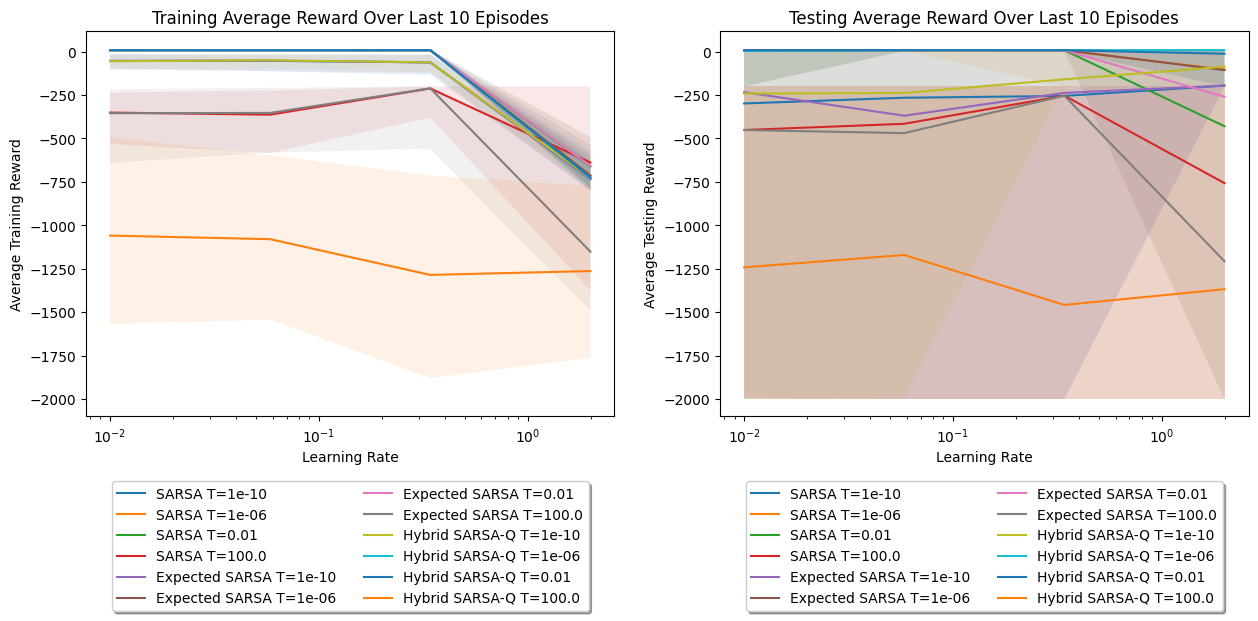

In [169]:
plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 2, 1)
# plot average training rewards
for i in range(len(temps)):
    plt.plot(alphas, sarsa_avg_train_rewards[i], label=f"SARSA T={temps[i]}")
    # add uncertainty regions by taking min and max of the last 10 segments
    plt.fill_between(alphas, sarsa_min_train_rewards[i], sarsa_max_train_rewards[i], alpha=0.1)
    
for i in range(len(temps)):
    plt.plot(alphas, expected_sarsa_avg_train_rewards[i], label=f"Expected SARSA T={temps[i]}")
    # add uncertainty regions
    plt.fill_between(alphas, expected_sarsa_min_train_rewards[i], expected_sarsa_max_train_rewards[i], alpha=0.1)
for i in range(len(temps)):
    plt.plot(alphas, hybrid_sarsa_q_avg_train_rewards[i], label=f"Hybrid SARSA-Q T={temps[i]}")
    # add uncertainty regions
    plt.fill_between(alphas, hybrid_sarsa_q_min_train_rewards[i], hybrid_sarsa_q_max_train_rewards[i], alpha=0.1)
plt.xlabel("Learning Rate")
plt.xticks(alphas)
plt.ylabel("Average Training Reward")
plt.title("Training Average Reward Over Last 10 Episodes")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)

plt.subplot(1, 2, 2, sharey=ax1, sharex=ax1)
# plot average test rewards
for i in range(len(temps)):
    plt.plot(alphas, sarsa_avg_test_rewards[i], label=f"SARSA T={temps[i]}")
    # add uncertainty regions
    plt.fill_between(alphas, sarsa_min_test_rewards[i], sarsa_max_test_rewards[i], alpha=0.1)
for i in range(len(temps)):
    plt.plot(alphas, expected_sarsa_avg_test_rewards[i], label=f"Expected SARSA T={temps[i]}")
    # add uncertainty regions
    plt.fill_between(alphas, expected_sarsa_min_test_rewards[i], expected_sarsa_max_test_rewards[i], alpha=0.1)
for i in range(len(temps)):
    plt.plot(alphas, hybrid_sarsa_q_avg_test_rewards[i], label=f"Hybrid SARSA-Q T={temps[i]}")
    # add uncertainty regions
    plt.fill_between(alphas, hybrid_sarsa_q_min_test_rewards[i], hybrid_sarsa_q_max_test_rewards[i], alpha=0.1)
plt.xlabel("Learning Rate")
plt.xticks(alphas)
plt.xscale('log')
plt.ylabel("Average Testing Reward")
plt.title("Testing Average Reward Over Last 10 Episodes")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.show()

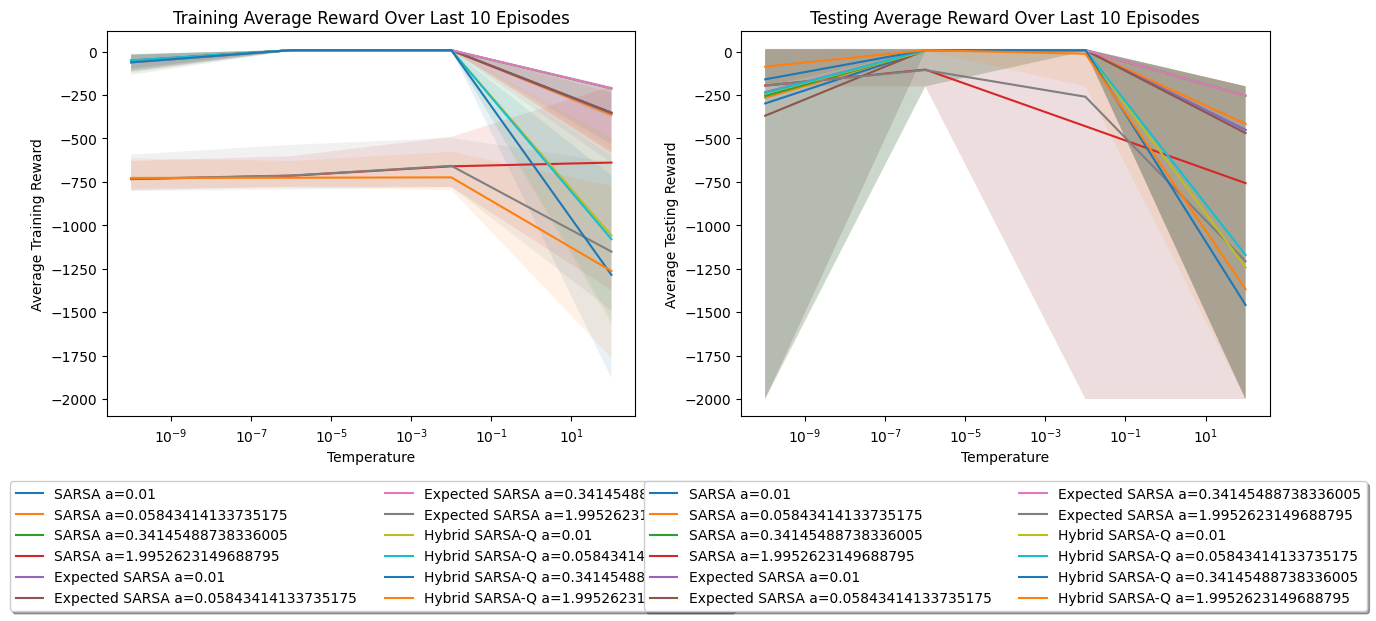

In [170]:
plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 2, 1)
# plot average training rewards
for i in range(len(alphas)):
    plt.plot(temps, sarsa_avg_train_rewards.T[i], label=f"SARSA a={alphas[i]}")
    # add uncertainty regions by taking min and max of the last 10 segments
    plt.fill_between(temps, sarsa_min_train_rewards.T[i], sarsa_max_train_rewards.T[i], alpha=0.1)

for i in range(len(alphas)):
    plt.plot(temps, expected_sarsa_avg_train_rewards.T[i], label=f"Expected SARSA a={alphas[i]}")
    # add uncertainty regions
    plt.fill_between(temps, expected_sarsa_min_train_rewards.T[i], expected_sarsa_max_train_rewards.T[i], alpha=0.1)

for i in range(len(alphas)):
    plt.plot(temps, hybrid_sarsa_q_avg_train_rewards.T[i], label=f"Hybrid SARSA-Q a={alphas[i]}")
    # add uncertainty regions
    plt.fill_between(temps, hybrid_sarsa_q_min_train_rewards.T[i], hybrid_sarsa_q_max_train_rewards.T[i], alpha=0.1)

plt.xlabel("Temperature")
plt.xticks(temps)
plt.ylabel("Average Training Reward")
plt.title("Training Average Reward Over Last 10 Episodes")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)

plt.subplot(1, 2, 2, sharey=ax1, sharex=ax1)
# plot average test rewards
for i in range(len(alphas)):
    plt.plot(temps, sarsa_avg_test_rewards.T[i], label=f"SARSA a={alphas[i]}")
    # add uncertainty regions
    plt.fill_between(temps, sarsa_min_test_rewards.T[i], sarsa_max_test_rewards.T[i], alpha=0.1)

for i in range(len(alphas)):
    plt.plot(temps, expected_sarsa_avg_test_rewards.T[i], label=f"Expected SARSA a={alphas[i]}")
    # add uncertainty regions
    plt.fill_between(temps, expected_sarsa_min_test_rewards.T[i], expected_sarsa_max_test_rewards.T[i], alpha=0.1)

for i in range(len(alphas)):
    plt.plot(temps, hybrid_sarsa_q_avg_test_rewards.T[i], label=f"Hybrid SARSA-Q a={alphas[i]}")
    # add uncertainty regions
    plt.fill_between(temps, hybrid_sarsa_q_min_test_rewards.T[i], hybrid_sarsa_q_max_test_rewards.T[i], alpha=0.1)

plt.xlabel("Temperature")
plt.xticks(temps)
plt.xscale('log')
plt.ylabel("Average Testing Reward")
plt.title("Testing Average Reward Over Last 10 Episodes")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.show()

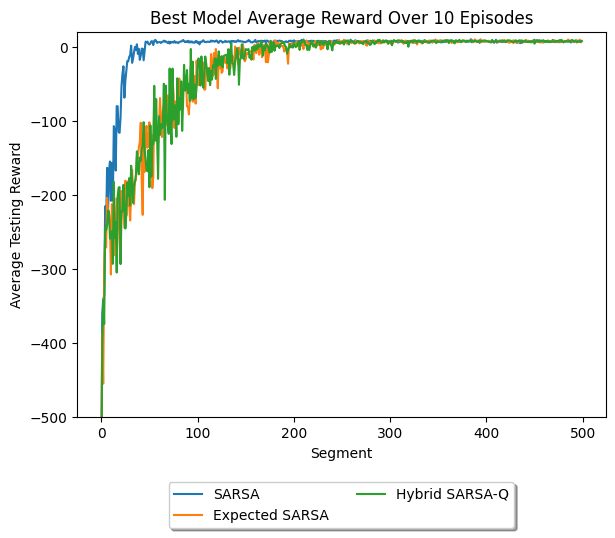

In [171]:
# Learning curves (mean and standard deviation computed based on the 10 runs) for the best
# parameter setting for each algorithm. X-axis shows the segment, Y-axis shows return over-
# time.
sarsa_idx = np.argmax(sarsa_avg_test_rewards.flatten())
sarsa_best_alpha = alphas[sarsa_idx // len(temps)]
sarsa_best_temp = temps[sarsa_idx % len(temps)]

expected_sarsa_idx = np.argmax(expected_sarsa_avg_test_rewards.flatten())
expected_sarsa_best_alpha = alphas[expected_sarsa_idx // len(temps)]
expected_sarsa_best_temp = temps[expected_sarsa_idx % len(temps)]

hybrid_sarsa_q_idx = np.argmax(hybrid_sarsa_q_avg_test_rewards.flatten())
hybrid_sarsa_q_best_alpha = alphas[hybrid_sarsa_q_idx // len(temps)]
hybrid_sarsa_q_best_temp = temps[hybrid_sarsa_q_idx % len(temps)]

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 2, sharey=ax1, sharex=ax1)
# plot average test rewards with curves and fill between the standard deviation
plt.plot(sarsa_train_rewards[0, alphas.index(sarsa_best_alpha), temps.index(sarsa_best_temp)], label="SARSA")
# plt.fill_between(range(num_segments), sarsa_test_rewards[:, alphas.index(sarsa_best_alpha), temps.index(sarsa_best_temp)].mean(axis=0) - sarsa_test_rewards[:, alphas.index(sarsa_best_alpha), temps.index(sarsa_best_temp)].std(axis=0), sarsa_test_rewards[:, alphas.index(sarsa_best_alpha), temps.index(sarsa_best_temp)].mean(axis=0) + sarsa_test_rewards[:, alphas.index(sarsa_best_alpha), temps.index(sarsa_best_temp)].std(axis=0), alpha=0.2)
plt.plot(expected_sarsa_train_rewards[0, alphas.index(expected_sarsa_best_alpha), temps.index(expected_sarsa_best_temp)], label="Expected SARSA")
# plt.fill_between(range(num_segments), expected_sarsa_test_rewards[:, alphas.index(expected_sarsa_best_alpha), temps.index(expected_sarsa_best_temp)].mean(axis=0) - expected_sarsa_test_rewards[:, alphas.index(expected_sarsa_best_alpha), temps.index(expected_sarsa_best_temp)].std(axis=0), expected_sarsa_test_rewards[:, alphas.index(expected_sarsa_best_alpha), temps.index(expected_sarsa_best_temp)].mean(axis=0) + expected_sarsa_test_rewards[:, alphas.index(expected_sarsa_best_alpha), temps.index(expected_sarsa_best_temp)].std(axis=0), alpha=0.2)
plt.plot(hybrid_sarsa_q_train_rewards[0, alphas.index(hybrid_sarsa_q_best_alpha), temps.index(hybrid_sarsa_q_best_temp)], label="Hybrid SARSA-Q")
# plt.fill_between(range(num_segments), hybrid_sarsa_q_test_rewards[:, alphas.index(hybrid_sarsa_q_best_alpha), temps.index(hybrid_sarsa_q_best_temp)].mean(axis=0) - hybrid_sarsa_q_test_rewards[:, alphas.index(hybrid_sarsa_q_best_alpha), temps.index(hybrid_sarsa_q_best_temp)].std(axis=0), hybrid_sarsa_q_test_rewards[:, alphas.index(hybrid_sarsa_q_best_alpha), temps.index(hybrid_sarsa_q_best_temp)].mean(axis=0) + hybrid_sarsa_q_test_rewards[:, alphas.index(hybrid_sarsa_q_best_alpha), temps.index(hybrid_sarsa_q_best_temp)].std(axis=0), alpha=0.2)
plt.xlabel("Segment")
plt.xscale('linear')
plt.ylabel("Average Testing Reward")
plt.ylim([-500,20])
plt.title("Best Model Average Reward Over 10 Episodes")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.show()

For our choise of parameters, we decided to use a gamma of 0.99 as there are many negative rewards and few positive rewards that are far in the future. Also we first tested the edges of our parameters such as temperature and learning rate such that on either end we would see decreased performance. Then we did a log space search between those two extremes to show what comes to be upside down u curves for the rewards. Some of the tests never complete which caps out at usually a -2000 reward hence why some of the error bars are so large. Taking the best parameters for each shows that the sarsa was the fastest to converge followed by the hybrid-sarsa-q and the expected sarsa.  Expected sarsa takes longer to converge than sarsa becuase it is more of a moving average of the rewards which causes it to be safer in the environment whereas sarsa can be more risky in it's exploration (hybrid-sarsa-q depends on how much each is weighted).

# Question 2

Suppose we are in an MDP and the reward function has the structure r(s,a) = αr1(s,a) + βr2(s,a) where α,β are real
numbers. In this question, we investigate whether we could solve the problems defined by reward
functions r1 and r2 independently and then somehow combine them linearly to solve the problem
defined by r. Assume the discounted setting with a given discount γ.

(a) [10 points] Suppose you are given the action-value functions qπ1 and qπ2 corresponding to the
action-value function of an arbitrary, fixed policy π under the two reward functions. Using the
Bellman equation, show if it is possible or not to combine these value functions in a simple
manner (linear) to obtain qπ corresponding to reward function r.

**Answer:**

Starting with the Bellman equation for the action-value function $q_{\pi}$:

$$q_{\pi}(s,a) = \sum_{s'} P(s' | s, a) [r(s,a) + \gamma \sum_{a'} \pi(a' | s') q_{\pi}(s',a')]$$

Substituting the reward function $r(s,a) = αr1(s,a) + βr2(s,a)$ we get:

$$q_{\pi}(s,a) = \sum_{s'} P(s' | s, a) [\alpha r1(s,a) + \beta r2(s,a) + \gamma \sum_{a'} \pi(a' | s') q_{\pi}(s',a')]$$

Substituting the action-value functions $q_{\pi1}$ and $q_{\pi2}$ we get:

$$q_{\pi}(s,a) = \sum_{s'} P(s' | s, a) [\alpha r1(s,a) + \beta r2(s,a) + \gamma \sum_{a'} \pi(a' | s') (\alpha q_{\pi1}(s',a') + \beta q_{\pi2}(s',a'))]$$

Now show this equaiton can be simplified to a linear combination of the value functions $q_{\pi1}$ and $q_{\pi2}$:

$$q_{\pi}(s,a) = \sum_{s'} P(s' | s, a) [\alpha r1(s,a) + \beta r2(s,a) + \gamma \sum_{a'} \pi(a' | s') \alpha q_{\pi1}(s',a') + \gamma \sum_{a'} \pi(a' | s') \beta q_{\pi2}(s',a')]$$

$$q_{\pi}(s,a) = \sum_{s'} P(s' | s, a) [\alpha r1(s,a) + \beta r2(s,a) + \gamma \alpha \sum_{a'} \pi(a' | s') q_{\pi1}(s',a') + \gamma \beta \sum_{a'} \pi(a' | s') q_{\pi2}(s',a')]$$

$$q_{\pi}(s,a) = \alpha \sum_{s'}(P(s' | s, a) r1(s,a) + \gamma \sum_{a'} \pi(a' | s') q_{\pi1}(s',a')) + \beta \sum_{s'}(P(s' | s, a) r2(s,a) + \gamma \sum_{a'} \pi(a' | s') q_{\pi2}(s',a'))$$

$$q_{\pi}(s,a) = \alpha q_{\pi1}(s,a) + \beta q_{\pi2}(s,a)$$

Therefore we can combine the value functions linearly to obtain $q_{\pi}$ corresponding to reward function r.

(b) [10 points] Suppose you are given the optimal action-value functions q∗1 and q∗2. Using the
Bellman equation, explain if it is possible or not to combine these value functions in a simple
manner (linear) to obtain q∗ which optimizes reward function r.

**Answer:**

Using the bellman equation for the optimal action-value function q∗:

$$q_{*}(s,a) =  \sum_{s'} P(s' | s, a) [r(s,a) + \gamma \max_{a'} q_{*}(s',a')]$$

Substituting q∗1 and q∗2 we get:

$$q_{*}(s,a) =  \sum_{s'} P(s' | s, a) [\alpha r1(s,a) + \beta r2(s,a) + \gamma \max_{a'} (\alpha q_{*1}(s',a') + \beta q_{*2}(s',a'))]$$

Since the max operator is not linear, we cannot combine the value functions q∗1 and q∗2 in a simple manner to obtain q∗ which optimizes reward function r.

# Question 3


Consider a learning algorithm which attempts to learn a Q-function, but instead of using the usual Q-learning target $r + \gamma \max_{a} Q(s',a)$, it uses as target a mixture of

$$R + \gamma((1 −α) max_{a} Q(s′,a) + α\sum_{a} \pi(s′,a)Q(s′,a))$$

where α ∈(0,1) is a hyper-parameter.

Assume that π is an ε-greedy policy derived from Q, and the episodes used for training are collected using π only.

(a) [5 points] Recall that an on-policy control algorithm estimates qπ(s,a) for the current behaviour policy π and for all states s and actions a. Is this algorithm on-policy or off-policy? Justify your answer.

**Answer:**

This is an off policy algorithm. The target is a mix of Q-learning and SARSA, which are off-policy and on-policy algorithms respectively. Since this policy is a mix of both, it is an off-policy algorithm as it is no longer purely on-policy.

(b) [5 points] For different values of α, how would you expect this algorithm to perform compared to Q-learning and SARSA? Include bias, variance, and maximization bias in your discussion.

**Answer:**

Since this algorithm is a combination of Q-learning and SARSA, you would expect this algorithm to perform in between them. When α = 0, the algorithm is equal to Q-learning, and when α = 1, the algorithm is equal to Sarsa so if α ∈ (0,1), the algorithm is a mix of both. The bias of the algorithm would be in between Q-learning and SARSA based on the value of α (closer to 0 for Q-learning implying less bias, and closer to 1 for SARSA implying more bias). The variance of the algorithm would be in between Q-learning and SARSA based on the value of α (closer to 0 for Q-learning implying more variance, and closer to 1 for SARSA implying less variance). Q-learning has a maximization bias, while SARSA does not and therefore combining the two can lead to the benifit of reducing the maximization bias while also increasing the variance allowing for exploration and finding the optimal policy faster.

(c) [5 points] Bonus question: try this algorithm on the Taxi Problem in Question 1, and compare it to the other algorithms. Are the results consistent with your hypothesis?

**Answer:**

The results are consistent with our hypothesis. The algorithm performs like a combination between Q-learning and SARSA. When α is close to 0, the algorithm performs closer to Q-learning, and when α is close to 1, the algorithm performs closer to SARSA and overall performs better than any of the other models.